In [21]:
import numpy as np
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import sys
import os
import cv2
%matplotlib inline

/var/folders/57/s96g49nn15dbw5ymslhc8lmh0000gp/T/ipykernel_29080/3099419231.py:2: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
# Computes the "energy" of an image, using the Laplacian of each colour channel and summing them up.
# Inputs: image, a 3d numpy array of size NxMx3
# Outputs: the energy image, a 2d numpy array of size NxM
def energy(image): 
    dy = np.array([-1, 0, 1])[:,None,None]
    dx = np.array([-1, 0, 1])[None,:,None]
    energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
    return np.sum(energy_img, axis=2)

In [3]:
def find_vertical_seam(energy):
    row = energy.shape[0]
    col = energy.shape[1]
    dp_energy = []
    dp_energy.append(energy[0].tolist())
        
    for i in range(1, row):
        temp = []
        for j in range(col):
            if j == 0:
                temp.append(energy[i][j] + min(dp_energy[i-1][j], dp_energy[i-1][j+1]))
            elif j == col - 1:
                temp.append(energy[i][j] + min(dp_energy[i-1][j], dp_energy[i-1][j-1]))
            else:
                temp.append(energy[i][j] + min(dp_energy[i-1][j-1], dp_energy[i-1][j], dp_energy[i-1][j+1]))
        dp_energy.append(temp)
    
    # backtracking to get the seam
    seam = [0] * row
    seam[row-1] = np.argmin(dp_energy[row-1])
    for i in range(row-2, -1, -1):
        j = seam[i+1]
        if j == 0:
            seam[i] = np.argmin(dp_energy[i][j:j+2]) + j
        elif j == col - 1:
            seam[i] = np.argmin(dp_energy[i][j-1:j+1]) + j-1
        else:
            seam[i] = np.argmin(dp_energy[i][j-1:j+2]) + j-1
    return seam

In [4]:
# Find the minimum-energy horizontal seam in an image. 
# Inputs: energy, a 2d numpy array containing the energy values. Size NxM.
# Outputs: a seam represented as a 1d array of length M, with all values between 0 and N-1. 
def find_horizontal_seam(energy):
    return find_vertical_seam(energy.T)

In [5]:
# Remove a vertical seam from an image:
# Inputs:  image, a 2d numpy array containing the pixel values. Size NxM.
#          seam, a 1d array (or list) containing the column index of each pixel in the seam. Length N, all values between 0 and M-1.
# Outputs: a new image that is smaller by 1 column. Size N by M-1.
def remove_vertical_seam(image, seam):
    height = image.shape[0]
    linear_inds = np.array(seam)+np.arange(image.shape[0])*image.shape[1]
    new_image = np.zeros((height,image.shape[1]-1,3), dtype="uint8")
    for c in range(3):
        temp = np.delete(image[:,:,c], linear_inds.astype(int)) 
        temp = np.reshape(temp, (height, image.shape[1]-1))
        new_image[:,:,c] = temp
    return new_image    


In [6]:
# Same as remove_vertical_seam above, but for a horizontal seam. The output image is size N-1 by M.
def remove_horizontal_seam(image, seam):
    return np.transpose(remove_vertical_seam(np.transpose(image,(1,0,2)), seam), (1,0,2))

In [7]:
# Resize an NxM image to a desired height and width. 
# Note: this function only makes images smaller. Enlarging an image is not implemented. 
# Inputs: image, a 3d numpy array of size NxMx3
#         desired_width, an integer giving the desired width
#         desired_height, an integer giving the desired height
# Outputs: the resized image, now of size N x desired_width x 3
def seam_carve(image, desired_height, desired_width):
    while image.shape[1] > desired_width:
        seam = find_vertical_seam(energy(image))
        assert len(seam) == image.shape[0], "the length of the seam must equal the height of the image"
        image = remove_vertical_seam(image, seam)
        sys.stdout.write('\rWidth is now %d' % image.shape[1])
    print()
    while image.shape[0] > desired_height:
        seam = find_horizontal_seam(energy(image))
        assert len(seam) == image.shape[1], "the length of the seam must equal the width of the image"
        image = remove_horizontal_seam(image, seam)
        sys.stdout.write('\rHeight is now %d' % image.shape[0])
    print()
    return image

In [19]:
def energy1(img):
    h, w = img.shape

    dx = np.concatenate((img, np.zeros((h, 1), dtype=int)), axis=1)[:,1:] - img[:,:]
    dy = np.concatenate((img, np.zeros((1, w), dtype=int)), axis=0)[1:,:] - img[:,:]

    return np.sqrt(dx*dx + dy*dy);

(2027, 1500, 3)
Width is now 1400
Height is now 1927


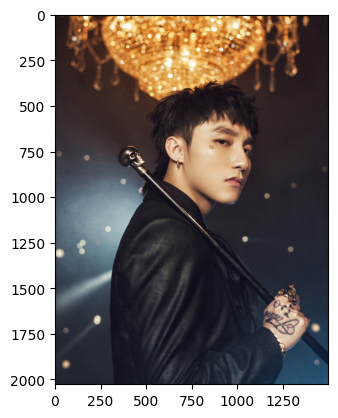

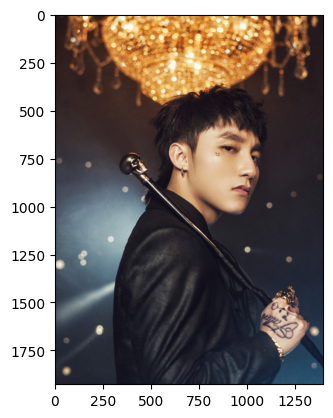

In [15]:
np.random.seed(1)
img = plt.imread('img.jpg')
print(img.shape)
h = img.shape[0] - 100
w = img.shape[1] - 100
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
img2 = seam_carve(img, h, w)
plt.figure()
plt.imshow(img2);